In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from collections import Counter

# Utils

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

#def get_mnist():
mnist_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/lazyprogrammer/data/mnist.csv', header='infer')

if mnist_df.isna().sum().max() == 0:
  print('There is no NA values')
else:
  print(f'There are {mnist_df.isna().sum().max()} NAs' )

mnist_df.head()

Mounted at /content/gdrive/
There is no NA values


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
def plot_misclasified_examples(x, true_lables, predicted_lables, n=5, print_misclassified=False, labels=None):
  misclassified_idx = np.where(predicted_lables != true_lables)[0]
  misclassified_random_idxes = np.random.choice(misclassified_idx, n*n)
  plt.figure(figsize=(15,15))
  for i in range(n*n):
      idx = misclassified_random_idxes[i]
      plt.subplot(n,n,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(x[idx], cmap='gray')
      if labels==None:
        plt.xlabel("True  %s, Pred: %s" % (true_lables[idx], predicted_lables[idx]))
      else:
        plt.xlabel("True  %s, Pred: %s" % (labels[true_lables[idx]], labels[predicted_lables[idx]]))
  plt.show()

  if print_misclassified:
      if labels==None:
        print(pd.DataFrame({'idx':misclassified_random_idxes,
                        'true':true_lables[misclassified_random_idxes],
                        'pred':predicted_lables[misclassified_random_idxes]}))
      else:
        print(pd.DataFrame({'idx':misclassified_random_idxes,
                        #'true':labels[true_lables[misclassified_random_idxes]],
                        'true':true_lables[misclassified_random_idxes],
                        #'pred':labels[predicted_lables[misclassified_random_idxes]]}))
                        'pred':predicted_lables[misclassified_random_idxes]}))

def plot_examples(x, y, cmap='gray', labels=None):
  plt.figure(figsize=(15,15))
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(x[i], cmap=cmap)
      if labels==None:
        plt.xlabel(y[i])
      else:
        plt.xlabel(labels[y[i]])
  plt.show()

In [4]:
def shuffle_pairs(X, Y):
  N = len(X)
  indexes = np.arange(N)
  np.random.shuffle(indexes)
  X = X[indexes]
  Y = Y[indexes]
  return X, Y


def get_mnist_data(should_shuffle = True, should_plot_examples=True):
  mnist_data = mnist_df.copy().values
  if (should_shuffle == True):
    np.random.shuffle(mnist_data)
  Y_mnist = mnist_data[:, 0]
  X_mnist = np.divide(mnist_data[:, 1:], 255.0)
  picture_shape = (28, 28)

  if (should_plot_examples == True):
    plot_examples(X_mnist.reshape((-1, *picture_shape)), Y_mnist, cmap='gray', labels=None)
  return X_mnist, Y_mnist, picture_shape


def get_xor_data(N=200, should_plot_data=True):
    X = np.zeros((N, 2))
    Nq = N // 4
    X[:Nq] = np.random.random((Nq, 2)) / 2 + 0.5 # (0.5-1, 0.5-1)
    X[Nq:2*Nq] = np.random.random((Nq, 2)) / 2 # (0-0.5, 0-0.5)
    X[2*Nq:3*Nq] = np.random.random((Nq, 2)) / 2 + np.array([[0, 0.5]]) # (0-0.5, 0.5-1)
    X[3*Nq:] = np.random.random((Nq, 2)) / 2 + np.array([[0.5, 0]]) # (0.5-1, 0-0.5)
    Y = np.array([0]*(N//2) + [1]*(N//2))

    X, Y = shuffle_pairs(X, Y)

    if (should_plot_data == True):
      plt.figure(figsize=(10,10))
      plt.scatter(X[:,0], X[:,1], c=Y, s=100, alpha=0.5);
      plt.title('Training data plot')
    return X, Y


def get_donut_data(N=200, should_plot_data=True):
    R_inner = 5
    R_outer = 10

    # distance from origin is radius + random normal
    # angle theta is uniformly distributed between (0, 2pi)
    R1 = np.random.randn(N//2) + R_inner
    theta = 2*np.pi*np.random.random(N//2)
    X_inner = np.concatenate([[R1 * np.cos(theta)], [R1 * np.sin(theta)]]).T

    R2 = np.random.randn(N//2) + R_outer
    theta = 2*np.pi*np.random.random(N//2)
    X_outer = np.concatenate([[R2 * np.cos(theta)], [R2 * np.sin(theta)]]).T

    X = np.concatenate([ X_inner, X_outer ])
    Y = np.array([0]*(N//2) + [1]*(N//2))
    
    X, Y = shuffle_pairs(X, Y)

    if (should_plot_data == True):
      plt.figure(figsize=(10,10))
      plt.scatter(X[:,0], X[:,1], c=Y, s=100, alpha=0.5);
      plt.title('Training data plot')
    return X, Y

# Decision Tree classifier class

In [5]:
def binary_entropy(y):
    # assume y is binary - 0 or 1
    N = len(y)
    s1 = (y == 1).sum()
    if 0 == s1 or N == s1:
        return 0
    p1 = float(s1) / N
    p0 = 1 - p1
    return -p0*np.log2(p0) - p1*np.log2(p1)


class BinaryTreeNode:
  split_column_idx = None
  split_value = None
  left_child = None
  right_child = None
  prediction = None
  information_gain = None

  def __init__(self, depth, max_depth=None, max_bucket_size=None, trace_logs=True):
    #print(f'Creating new node with depth={depth}')
    self.depth = depth
    self.max_depth = max_depth
    self.max_bucket_size = max_bucket_size
    self.trace_logs = trace_logs
    if self.max_depth is not None and self.max_depth < self.depth:
      raise Exception(f'depth > max_depth:{depth > max_depth}, depth={depth}, max_depth={max_depth}')

  def fit(self, X, Y):
    if (self.trace_logs == True):
      print(f'fit (depth:{self.depth}) - Start fit')
      #print(f'fit (depth:{self.depth}) - X:{X}')
      #print(f'fit (depth:{self.depth}) - Y:{Y}')
    if (self._is_fitted() == False):
      if(self._can_split(Y)):
        #print('Is allowed to split')
        split_column, self.split_value, self.information_gain = self._find_best_split(X, Y)
        if (self.trace_logs == True):
          print(f'fit (depth:{self.depth}) - (best_split_col, best_split_value, max_ig):{(split_column, self.split_value, self.information_gain)}')
        if (split_column is None):
          #print('fit (depth:{self.depth}) - no splits found, will make this node a leaf')
          self.prediction = self._calc_prediction(Y)
          #print(f'fit (depth:{self.depth}) - Leaf on level {self.depth}, calculated prediction={self.prediction}')
          return
          
        self.split_column_idx = int(split_column)
        left_split_mask = self._get_left_split_mask(X[:, self.split_column_idx], self.split_value)
        X_left, X_right = X[left_split_mask], X[~left_split_mask]
        Y_left, Y_right = Y[left_split_mask], Y[~left_split_mask]
        #print(f'fit (depth:{self.depth}) - Y_left len:{len(Y_left)}, Y_right len:{len(Y_right)}')
        #print(f'fit (depth:{self.depth}) - Y before split len:{len(Y)}, Y:{Y}')
        self.left_child = BinaryTreeNode(self.depth + 1, self.max_depth, self.max_bucket_size, trace_logs=self.trace_logs)
        self.left_child.fit(X_left, Y_left)
        self.right_child = BinaryTreeNode(self.depth + 1, self.max_depth, self.max_bucket_size, trace_logs=self.trace_logs)
        self.right_child.fit(X_right, Y_right)
      else:
        #print('fit (depth:{self.depth}) - Is not allowed to split')
        #print('fit (depth:{self.depth}) - Y:', Y)
        self.prediction = self._calc_prediction(Y)
        #print(f'fit (depth:{self.depth}) - Calculated prediction={self.prediction}')

  def predict(self, X):
    result = np.zeros(len(X))
    #print(f'predict - node level={self.depth}')
    if (self._is_leaf() == True):
      #print('Node has not childrens')
      #print('predict - self.prediction:', self.prediction)
      return self.prediction
    left_split_mask = self._get_left_split_mask(X[:, self.split_column_idx], self.split_value)

    left_predictions = self.left_child.predict(X[left_split_mask])
    right_predictions = self.right_child.predict(X[~left_split_mask])
    #print(f'predict - left_predictions:{left_predictions}, left_split_mask:{left_split_mask}')
    #print(f'predict - right_predictions:{right_predictions}, right_split_mask:{~left_split_mask}')

    #print('predict - left_split_mask:', left_split_mask)
    result[left_split_mask] = left_predictions
    result[~left_split_mask] = right_predictions
    #print('predict - result:', result)
    return result
  
  def get_importance(self):
    #tabs = '\t'*self.depth
    #print(f'{tabs}get_importance - node level {self.depth}')
    if (self._is_fitted() == False):
      raise Exception(f'Node on level {self.depth} is not fitted yet')
    if (self._is_leaf()): # no split no gain
      return np.array([(0, 0)])
    left_importance = self.left_child.get_importance()
    #print(f'{tabs}get_importance on level {self.depth} - left_importance:{left_importance}')
    right_importance = self.right_child.get_importance()
    #print(f'{tabs}get_importance on level {self.depth} - right_importance:{right_importance}')
    return self._calc_node_level_total_importance(left_importance, right_importance)

  def _calc_node_level_total_importance(self, left_child_importance, right_child_importance):
    tabs = '\t'*self.depth
    importances = np.concatenate((left_child_importance, right_child_importance, np.array([[self.split_column_idx, self.information_gain]])))
    #print(f'{tabs}_calc_node_level_total_importance on level {self.depth} - not summed importances:')
    #print(importances)
    importances_df = pd.DataFrame(importances, columns=['col_idx', 'information_gain'])
    importance = importances_df.groupby('col_idx', as_index=False).sum().values
    #print(f'{tabs}_calc_node_level_total_importance on level {self.depth} - summed importance:')
    #print(importance)
    return importance

  def _is_fitted(self):
    has_no_split_details = self.split_column_idx is None and self.split_value is None and self.left_child is None and self.right_child is None
    if (self.prediction is None and has_no_split_details): # not a leaf neither splitted
      return False
    if (self.prediction is not None and has_no_split_details == True): # is leaf
      return True
    has_split_details = self.split_column_idx is not None and self.split_value is not None and self.left_child is not None and self.right_child is not None
    if (self.prediction is None and has_split_details == True): # is splitted
      return True
    raise Exception(f'There are conflicting values in self.prediction and other attributes related to node split')

  def _is_leaf(self):
    if (self._is_fitted()):
      return self.prediction is not None
    return False
     
  def _can_split(self, Y):
    #True if all below
    # 1. depth not bigger than allowed => self.depth <= self.max_depth
    # 2. num of obserwations bigger than requested => len(Y) > self.max_bucket_size
    # 3. there is any variation in labels => (len(set(Y)) == 1) > 1
    allowed = True
    #print('should_try_split - result:', allowed)
    if (self.max_depth is not None):
      #print(f'self.max_depth is not None and node.depth <= self.max_depth={node.depth <= self.max_depth}, node.depth={node.depth}, self.max_depth={self.max_depth}')
      allowed = allowed and self.depth < self.max_depth
    #print('should_try_split - result:', allowed)
    if (self.max_bucket_size is not None):
      #print(f'self.max_bucket_size is not None and bucket_size > self.max_bucket_size={bucket_size > self.max_bucket_size}, node.bucket_size={bucket_size}, self.max_bucket_size={self.max_bucket_size}')
      allowed = allowed and len(Y) > self.max_bucket_size
    if (len(Y) == 1 or len(set(Y)) == 1):
      return False
    #print('should_try_split - result:', allowed)
    return allowed
    
  def _find_best_split(self, X, Y):
    splits = self._get_split_candidates(X, Y)
    #print('_find_best_split - splits:', pd.DataFrame(splits, columns=['column_idx', 'split_value', 'ig']))
    if (len(splits) == 0):
      return (None, None, None)
    return splits[np.argmax(splits[:,2])]
    
  def _get_split_candidates(self, X, Y):
    splits = []
    for i in range(X.shape[1]):
      X_col = X[:,i]
      if (len(set(X_col)) == 1):
        #print(f'_find_all_splits - all split column {i} valueas are same (={X[:,i][0]}) and should no split further')
        continue
      sort_idx = np.argsort(X_col)
      X_col_sorted = X_col[sort_idx]
      Y_sorted = Y[sort_idx]
      steps_idx = self._get_steps(Y_sorted)
      #print(f'_find_all_splits - column={i}, steps_idx:{steps_idx}, X_col_sorted:{X_col_sorted}, Y_sorted:{Y_sorted}')
      for s_idx in steps_idx:
        split_point = (X_col_sorted[s_idx] + X_col_sorted[s_idx+1]) / 2.0
        #print('_find_all_splits - split_point:', split_point)
        left_split_mask = self._get_left_split_mask(X_col, split_point)
        ig = self._calc_information_gain(Y[left_split_mask], Y[~left_split_mask])
        #print('_find_all_splits - calculated information gain:', ig)
        splits.append([i, split_point, ig])
    return np.array(splits)

  def _calc_prediction(self, Y):
    if (len(Y) == 1 or len(set(Y)) == 1):
      return Y[0]
    return int(np.round(Y.mean()))

  def _get_left_split_mask(self, x, split_by_value):
    #print(f'_get_left_split_mask - split_by_value:{split_by_value}')
    #print(f'_get_left_split_mask - x:{x}')
    left_split_mask = x < split_by_value
    #print('_get_split_mask - left_split_mask:', left_split_mask)
    return left_split_mask

  def _calc_information_gain(self, y0, y1):
    #print(f'_calc_information_gain - y0:{y0}')
    #print(f'_calc_information_gain - y1:{y1}')
    N_0 = len(y0)
    N_1 = len(y1)
    N = N_0 + N_1
    if (N_0 == 0 or N_1 == 0):
      #print(f'_calc_information_gain - one leg (left:{N_0}, right:{N_1}) is lenght of 0 so 0 is returned as information gain')
      return 0
    y = np.concatenate((y0, y1))
    #print(f'_calc_information_gain - concatenation of left:{y0}, right:{y1}, result:{y}')
    #print(f'_calc_information_gain - binary_entropy(y):{binary_entropy(y)}, binary_entropy(y0):{binary_entropy(y0)}, binary_entropy(y1):{binary_entropy(y1)}')
    return binary_entropy(y) - (N_0 * binary_entropy(y0) + N_1 * binary_entropy(y1)) / N

  def _get_steps(self, Y):
    return np.nonzero(Y[:-1] != Y[1:])[0]


class BinaryTreeClassifier:
  def __init__(self, max_depth=10, max_bucket_size=10, trace_logs=True):
    self.max_depth = max_depth
    self.max_bucket_size = max_bucket_size
    self.trace_logs = trace_logs
  
  def fit(self, X, Y):
    self.head = BinaryTreeNode(1, self.max_depth, self.max_bucket_size, trace_logs=self.trace_logs)
    self.head.fit(X, Y)

  def predict(self, X):
    return self.head.predict(X)
    
  def score(self, X, Y):
    predictions = self.predict(X)
    return np.mean(predictions == Y)
  
  def get_importance(self):
    return self.head.get_importance()

# Simple sanity test

In [6]:
def _test():
  q=np.array([1,4,-999,1,2,8,19,2,7,16,3,1,34,12,19,2,1111,55,3,55,34,9,9,27788,657456456456,16,77,1,2,8,19,2,1111,16,3,1,34,12,19,2,12,55,3,55,34,9,9,5645,1,16,-1239,1,2,8,19,2,8,16,3,1,34,12,19,2,1111,55,3,55,34,9,9,27788,1,16,-1239,1,2,8,19,2,1111,16,3,1,34,12,19,2,1111,55,3,55,34,9,9,27788]).reshape((-1,3))
  qy=np.array([0,1,1,1,0,1,0,1,0,1,1,1,0,1,0,1,0,1,1,1,0,1,0,1,0,1,1,1,0,1,0,1])

  #q=np.array([7,7,7,7,7,7,7,7,7,7]).reshape((-1,1))
  #qy=np.array([0,1,1,1,0,0,1,1,1,0])

  model = BinaryTreeClassifier(5, 1)
  model.fit(q, qy)

  q_pred=np.array([1,1,1,1,1]).reshape((-1,1))
  qy_pred=np.array([0,1,1,1,])

  q_pred=np.array([1,1,19,1,19,1,19,1,19]).reshape((-1,1))

  print(model.predict(q) == qy)

  imp = model.get_importance()
  print(f'test result imporatnce:{imp}')

_test()

fit (depth:1) - Start fit
fit (depth:1) - (best_split_col, best_split_value, max_ig):(1.0, 12.0, 0.39079402072579994)
fit (depth:2) - Start fit
fit (depth:2) - (best_split_col, best_split_value, max_ig):(2.0, -499.0, 0.3227569588973983)
fit (depth:3) - Start fit
fit (depth:3) - Start fit
fit (depth:2) - Start fit
fit (depth:2) - (best_split_col, best_split_value, max_ig):(2.0, 44.5, 0.5959980436453798)
fit (depth:3) - Start fit
fit (depth:3) - Start fit
fit (depth:3) - (best_split_col, best_split_value, max_ig):(0.0, 328728228229.0, 0.7219280948873623)
fit (depth:4) - Start fit
fit (depth:4) - Start fit
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
test result imporatnce:[[0.         0.72192809]
 [1.         0.39079402]
 [2.         0.918755  ]]


# Run model utils

In [7]:
def run_model(X, Y, N=2000, max_depth=10, max_bucket_size=10, trace_logs=True):
  X_train, X_test = X[:N//2], X[N//2:N]
  Y_train, Y_test = Y[:N//2], Y[N//2:N]

  model = BinaryTreeClassifier(max_depth, max_bucket_size, trace_logs=trace_logs)

  #print('Y_train:', Y_train)
  t0 = datetime.now()
  model.fit(X_train,Y_train)
  print(f'Fitted within {datetime.now()-t0} time')

  t0 = datetime.now()
  acc = model.score(X_train,Y_train)
  print(f'Predicted within {datetime.now()-t0} time with train accuracy={acc}')
    
  t0 = datetime.now()
  acc = model.score(X_test,Y_test)
  print(f'Predicted within {datetime.now()-t0} time with test accuracy={acc}')

  return model

# Use BinaryTreeClassifier

##  for MNIST

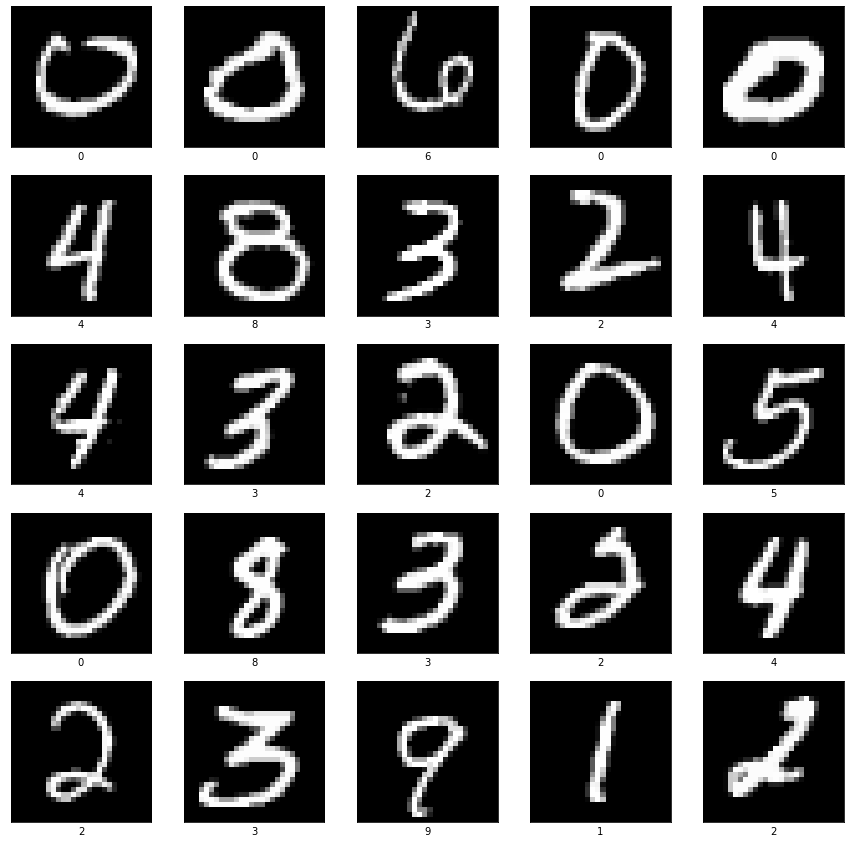

In [8]:
X, Y, pic_shape = get_mnist_data()
idxs = np.logical_or(Y==0, Y==1)
X = X[idxs].copy()
Y = Y[idxs].copy()

In [9]:
model = run_model(X, Y, N=10000, max_depth=7, max_bucket_size=None)
imp = pd.DataFrame(model.get_importance(), columns=['columns_id', 'imporatnce'])
sorted_imp = imp.sort_values(by='imporatnce', ascending=False)
print(f'Imporatnce:{sorted_imp}')

fit (depth:1) - Start fit
fit (depth:1) - (best_split_col, best_split_value, max_ig):(434.0, 0.06470588235294117, 0.9049548964073856)
fit (depth:2) - Start fit
fit (depth:2) - (best_split_col, best_split_value, max_ig):(461.0, 0.1588235294117647, 0.022956340263959325)
fit (depth:3) - Start fit
fit (depth:3) - (best_split_col, best_split_value, max_ig):(435.0, 0.5627450980392157, 0.011123871593775939)
fit (depth:4) - Start fit
fit (depth:4) - Start fit
fit (depth:4) - (best_split_col, best_split_value, max_ig):(127.0, 0.10784313725490197, 0.9544340029249649)
fit (depth:5) - Start fit
fit (depth:5) - Start fit
fit (depth:3) - Start fit
fit (depth:3) - (best_split_col, best_split_value, max_ig):(494.0, 0.01568627450980392, 0.47995779683750056)
fit (depth:4) - Start fit
fit (depth:4) - (best_split_col, best_split_value, max_ig):(235.0, 0.7019607843137254, 0.8960382325345573)
fit (depth:5) - Start fit
fit (depth:5) - Start fit
fit (depth:4) - Start fit
fit (depth:2) - Start fit
fit (depth:2

## for xor

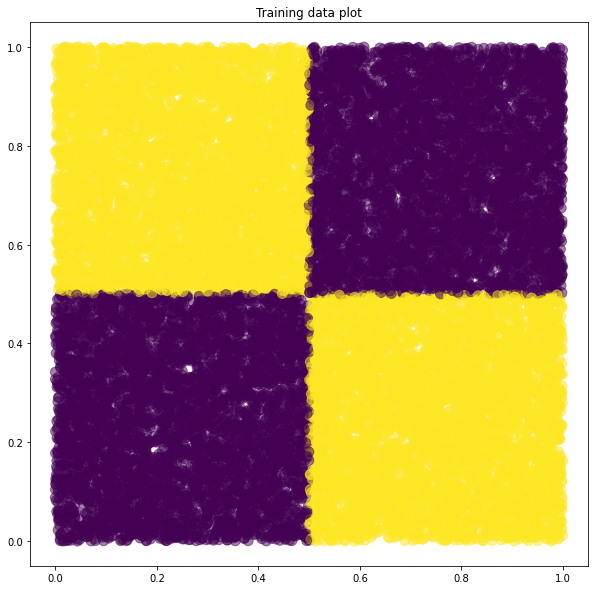

In [10]:
N = 20000
X, Y = get_xor_data(N)

In [11]:
model = run_model(X, Y, N=N, max_depth=10, max_bucket_size=None)
imp = pd.DataFrame(model.get_importance(), columns=['columns_id', 'imporatnce'])
sorted_imp = imp.sort_values(by='imporatnce', ascending=False)
print(f'Imporatnce:{sorted_imp}')

fit (depth:1) - Start fit
fit (depth:1) - (best_split_col, best_split_value, max_ig):(0.0, 0.9796823917220443, 0.0010523424211237309)
fit (depth:2) - Start fit
fit (depth:2) - (best_split_col, best_split_value, max_ig):(1.0, 0.5077747636858423, 0.0007335919027529059)
fit (depth:3) - Start fit
fit (depth:3) - (best_split_col, best_split_value, max_ig):(0.0, 0.4999993033619455, 0.8715704058583428)
fit (depth:4) - Start fit
fit (depth:4) - (best_split_col, best_split_value, max_ig):(1.0, 0.500282483265662, 0.09450322961126773)
fit (depth:5) - Start fit
fit (depth:5) - Start fit
fit (depth:4) - Start fit
fit (depth:4) - (best_split_col, best_split_value, max_ig):(1.0, 0.4997198023505091, 0.1623776753954428)
fit (depth:5) - Start fit
fit (depth:5) - Start fit
fit (depth:3) - Start fit
fit (depth:3) - (best_split_col, best_split_value, max_ig):(0.0, 0.5001071946840177, 0.9990441339103724)
fit (depth:4) - Start fit
fit (depth:4) - Start fit
fit (depth:2) - Start fit
fit (depth:2) - (best_spli

## for donut

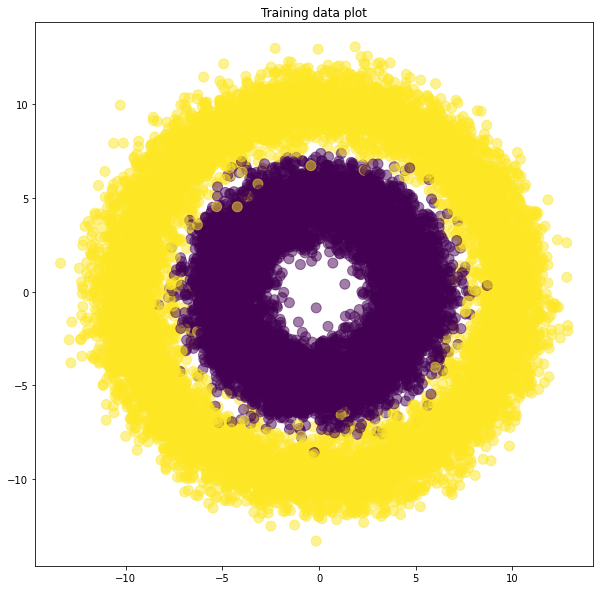

In [12]:
N = 20000
X, Y = get_donut_data(N)

In [13]:
model = run_model(X, Y, N=N, max_depth=20, max_bucket_size=None)
imp = pd.DataFrame(model.get_importance(), columns=['columns_id', 'imporatnce'])
sorted_imp = imp.sort_values(by='imporatnce', ascending=False)
print(f'Imporatnce:{sorted_imp}')

fit (depth:1) - Start fit
fit (depth:1) - (best_split_col, best_split_value, max_ig):(1.0, 6.865886859856752, 0.1413790380251413)
fit (depth:2) - Start fit
fit (depth:2) - (best_split_col, best_split_value, max_ig):(1.0, -6.529838963410407, 0.1933778597192588)
fit (depth:3) - Start fit
fit (depth:3) - (best_split_col, best_split_value, max_ig):(1.0, -7.789319768626331, 0.0442129762699692)
fit (depth:4) - Start fit
fit (depth:4) - Start fit
fit (depth:4) - (best_split_col, best_split_value, max_ig):(0.0, -4.031189115502282, 0.06798199015005496)
fit (depth:5) - Start fit
fit (depth:5) - Start fit
fit (depth:5) - (best_split_col, best_split_value, max_ig):(0.0, 1.775602453493433, 0.2640975501952187)
fit (depth:6) - Start fit
fit (depth:6) - (best_split_col, best_split_value, max_ig):(1.0, -7.1919235916011335, 0.3607605535357872)
fit (depth:7) - Start fit
fit (depth:7) - (best_split_col, best_split_value, max_ig):(1.0, -7.511451653765949, 0.19523069587034525)
fit (depth:8) - Start fit
fit 